In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [7]:
cardiac_features = pd.read_csv('ECG_Cardiac_Features.csv')
cardiac_features.drop(columns=['Patient_ID'], inplace=True)
fourier_features = pd.read_csv('ECG_Fourier_Transform_Features.csv')
fourier_features.drop(columns=['Patient_ID', 'Label'], inplace=True)
time_features = pd.read_csv('ECG_Time_Features.csv')
cnn_features = pd.read_csv('CNN_Features.csv')
cnn_features.drop(columns=['Patient_ID', 'Label'], inplace=True)

# Step 2: Merge features into FAD and FCNN
merged_features = pd.merge(cardiac_features, fourier_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, time_features, on='ecg_id', how='inner')

print(merged_features.columns)

label_encoder = LabelEncoder()
merged_features['Label'] = label_encoder.fit_transform(merged_features['Label'])


merged_features.head()

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       'RR Interval SD', 'RR Interval RMSSD', 'RR Interval Min',
       'RR Interval Max', 'QT Interval Mean', 'QT Interval SD',
       'ST Segment Amplitude Mean', 'ST Segment Amplitude SD',
       'ST Segment Duration Mean', 'ST Segment Duration SD',
       'Dominant Frequency', 'Frequency Power Sum', 'Mean Frequency',
       'Spectral Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'value__quantile__q_0.9', 'value__quantile__q_0.6',
       'value__quantile__q_0.4', 'value__quantile__q_0.7',
       'value__quantile__q_0.1', 'value__quantile__q_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles

,ecg_id,Label,Heart Rate,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,QRS_duration,PR_duration,RR Interval Mean,...,"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__fft_coefficient__attr_""abs""__coeff_17","value__fft_coefficient__attr_""abs""__coeff_11",value__lempel_ziv_complexity__bins_10,value__partial_autocorrelation__lag_3,value__partial_autocorrelation__lag_4,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",value__skewness,value__fourier_entropy__bins_3
0,1,3,63.847119,940.000000,17.320508,22.627417,0.000000,141.714286,127.333333,940.000000,...,0.065170,9.043106,74.502545,0.0838,-1.512835,2.218194,0.000088,0.000030,2.905521,0.220352
1,2,3,47.838174,1258.285714,82.836615,54.546616,42.857143,174.285714,152.000000,1258.285714,...,0.574924,58.900234,24.919214,0.0786,-1.059925,11.497906,0.000202,0.000027,2.195819,0.079983
2,3,3,63.822587,940.444444,20.019435,17.606817,0.000000,130.750000,114.500000,940.444444,...,0.125145,6.973763,100.593283,0.0810,-1.793943,1.794352,0.000112,0.000049,2.827517,0.183378
3,4,3,75.152692,800.545455,45.511237,35.185224,9.090909,160.727273,110.000000,800.545455,...,0.169628,29.327653,40.714874,0.0904,-1.299110,3.141033,0.000451,0.000043,0.282202,0.125256
4,5,3,66.456900,905.200000,51.018080,57.271284,50.000000,NaN,122.000000,905.200000,...,0.151764,5.776241,79.793704,0.0842,-1.839826,1.745159,0.000152,0.000018,1.634762,0.190068


In [8]:
print(merged_features.columns)
print(merged_features.shape)

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       'RR Interval SD', 'RR Interval RMSSD', 'RR Interval Min',
       'RR Interval Max', 'QT Interval Mean', 'QT Interval SD',
       'ST Segment Amplitude Mean', 'ST Segment Amplitude SD',
       'ST Segment Duration Mean', 'ST Segment Duration SD',
       'Dominant Frequency', 'Frequency Power Sum', 'Mean Frequency',
       'Spectral Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'value__quantile__q_0.9', 'value__quantile__q_0.6',
       'value__quantile__q_0.4', 'value__quantile__q_0.7',
       'value__quantile__q_0.1', 'value__quantile__q_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles

In [9]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 1 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 2814 missing values
PR_duration: 3221 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 198 missing values
QT Interval SD: 198 missing values
ST Segment Amplitude Mean: 186 missing values
ST Segment Amplitude SD: 186 missing values
ST Segment Duration Mean: 186 missing values
ST Segment Duration SD: 186 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MF

In [10]:
classes = list(merged_features['Label'].unique())

feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    merged_features[col] = merged_features.groupby('Label')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [11]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 0 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 0 missing values
PR_duration: 0 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 0 missing values
QT Interval SD: 0 missing values
ST Segment Amplitude Mean: 0 missing values
ST Segment Amplitude SD: 0 missing values
ST Segment Duration Mean: 0 missing values
ST Segment Duration SD: 0 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MFCC_10: 0 missing v

In [13]:
aligned_cnn_features = cnn_features[cnn_features['ecg_id'].isin(merged_features['ecg_id'])]
aligned_features = merged_features[merged_features['ecg_id'].isin(aligned_cnn_features['ecg_id'])]
aligned_features = aligned_features.sort_values(by='ecg_id')
aligned_cnn_features = aligned_cnn_features.sort_values(by='ecg_id')

X_features = aligned_features.drop(columns=['ecg_id', 'Label']).values
y_features = aligned_features['Label'].values

# X_cnn = aligned_cnn_features.drop(columns=['ecg_id', 'Label']).values
# y_cnn = aligned_cnn_features['Label'].values

FAD = aligned_features.drop(columns=['ecg_id']).values
# FCNN = aligned_cnn_features.drop(columns=['ecg_id']).values

In [14]:
print(aligned_features.shape)
# print(aligned_cnn_features.shape)

(20794, 87)


In [16]:
import umap.umap_ as umap

umap_reducer = umap.UMAP(n_components=50)
FAD_reduced = umap_reducer.fit_transform(X_features)
# FCNN_reduced = umap_reducer.fit_transform(FCNN)

In [ ]:
# df = pd.DataFrame(FAD_reduced)
# df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,9.260849,5.239030,3.909028,6.008908,3.440070,2.781296,2.661291,3.453546,4.128285,5.902029,...,5.238801,5.668771,5.859787,3.514190,4.578653,5.241035,4.935599,5.589700,4.311023,4.089324
1,7.953912,2.188119,7.224201,6.378866,6.948620,7.217815,5.913266,3.355639,2.532582,4.830278,...,4.477046,5.496073,5.759365,4.285308,5.346959,5.462299,4.933990,4.711164,5.535309,5.222966
2,8.495467,3.132640,6.843227,7.487651,4.495016,6.057387,7.605961,6.445122,4.413964,2.722969,...,4.363389,4.171052,4.979487,3.703028,4.399391,5.191483,5.020782,5.460652,4.700311,4.861674
3,7.526603,1.618747,6.962736,5.165802,7.982140,6.357637,3.651312,2.700475,4.492178,7.924686,...,4.497758,4.502831,5.266694,3.872856,4.955420,5.475580,4.886382,4.773436,5.456645,5.034745
4,9.501169,5.901619,2.474905,4.389650,5.732795,4.629847,4.110887,3.559430,3.079666,2.754826,...,4.340055,4.191410,4.673854,4.633540,4.690760,4.893185,5.222775,4.589536,5.745973,5.699281


In [22]:
FEns = FAD_reduced
y = y_features
FEns_sign = np.sign(FEns)  # Compute the sign of FEns
FEns_abs_log = np.log10(np.abs(FEns) + 1e-10)  # Add epsilon to avoid log(0)
Fnorm = -FEns_sign * FEns_abs_log  # Apply normalization

In [23]:
Fnorm_df = pd.DataFrame(Fnorm)
print(Fnorm_df.head())


# print(Fnorm_df.columns)
# X = Fnorm_df.values
# y = merged_features['Label'].values

         0         1         2         3         4         5         6   \
0 -0.966651 -0.719251 -0.592069 -0.778796 -0.536567 -0.444247 -0.425092   
1 -0.900581 -0.340071 -0.858790 -0.804743 -0.841899 -0.858406 -0.771827   
2 -0.929187 -0.495910 -0.835261 -0.874346 -0.652731 -0.782285 -0.881154   
3 -0.876599 -0.209179 -0.842780 -0.713138 -0.902119 -0.803296 -0.562449   
4 -0.977777 -0.770971 -0.393559 -0.642430 -0.758366 -0.665567 -0.613936   

         7         8         9   ...        40        41        42        43  \
0 -0.538265 -0.615770 -0.771001  ... -0.719232 -0.753489 -0.767882 -0.545825   
1 -0.525775 -0.403564 -0.683972  ... -0.650992 -0.740052 -0.760375 -0.631982   
2 -0.809231 -0.644829 -0.435043  ... -0.639824 -0.620246 -0.697185 -0.568557   
3 -0.431440 -0.652457 -0.898982  ... -0.652996 -0.653486 -0.721538 -0.588031   
4 -0.551381 -0.488504 -0.440094  ... -0.637495 -0.622360 -0.669675 -0.665913   

         44        45        46        47        48        49  
0 -0

In [24]:
X = Fnorm_df
y = aligned_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# X = merged_features[feature_columns]
# y = merged_features['Label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Accuracy: 0.36234671796104834


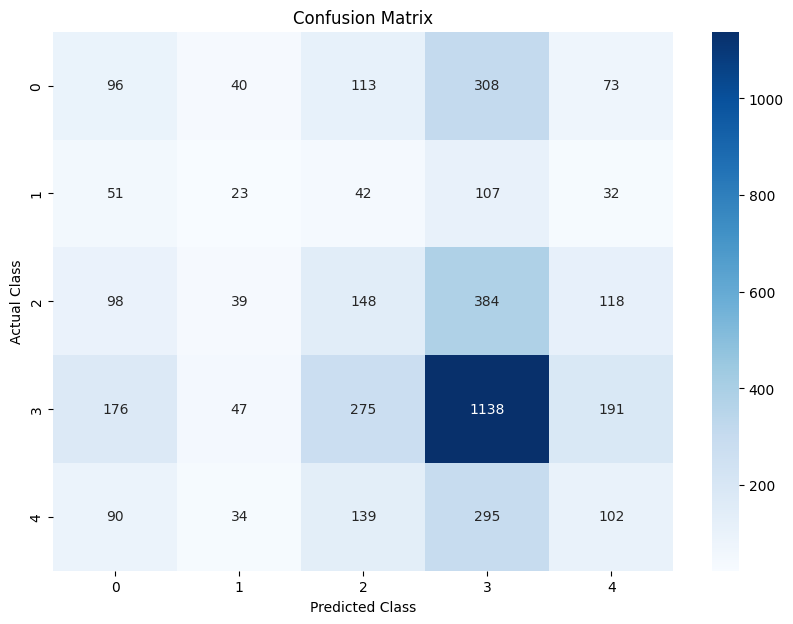

In [26]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_rf)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
labels = sorted(set(y_test) | set(y_pred))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

In [27]:
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

X_train_cnn_lstm = np.expand_dims(X_train, axis=2)  # Adding a channel dimension
X_test_cnn_lstm = np.expand_dims(X_test, axis=2)

# Define the CNN-LSTM model
cnn_lstm_model = Sequential([
    # CNN for automatic feature extraction
    Input(shape=(X_train.shape[1], 1)),  # Input shape: (features, channels)
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # LSTM for sequential detection
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.4),

    # Fully connected layer for classification
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model.fit(X_train_cnn_lstm, y_train_onehot, epochs=25, batch_size=64, validation_data=(X_test_cnn_lstm, y_test_onehot))

# Evaluate the model
cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test_cnn_lstm, y_test_onehot, verbose=0)
print(f"CNN-LSTM Test Accuracy: {cnn_lstm_accuracy:.2f}")


Epoch 1/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4249 - loss: 1.4467 - val_accuracy: 0.4484 - val_loss: 1.3966
Epoch 2/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4493 - loss: 1.3974 - val_accuracy: 0.4487 - val_loss: 1.3946
Epoch 3/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4552 - loss: 1.3930 - val_accuracy: 0.4528 - val_loss: 1.3836
Epoch 4/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4603 - loss: 1.3834 - val_accuracy: 0.4535 - val_loss: 1.3836
Epoch 5/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4531 - loss: 1.3810 - val_accuracy: 0.4530 - val_loss: 1.3860
Epoch 6/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4550 - loss: 1.3858 - val_accuracy: 0.4518 - val_loss: 1.3820
Epoch 7/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4582 - loss: 1.3786 - val_accuracy: 0.4535 - val_loss: 1.3833
Epoch 8/25
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4581 - loss: 1.3770 - val_acc

KeyboardInterrupt: 